In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-12-01

Goals: 
Analyze the data

Each Section can/should be able to run independently,
only these initial imports should be shared among all sections

"""
import numpy as np
import pandas as pd
import time

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import JaxPeriodDrwFit


from tape.ensemble import Ensemble
from tape.utils import ColumnMapper

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.adapt(minimum=1, maximum=40) 

ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33787,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:36151,Total threads: 8
Dashboard: http://127.0.0.1:46087/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:34229,


In [3]:
# Setup base directory for loading files
username= "ncaplar"
basedir = f"/astro/users/{username}/data"

# Tape Single Pixel - real data 

In [49]:
"""
0. Negative log-likelihood of the Gaussian Process model
1. log_drw_scale = theta[0]
2. log_drw_amp = theta[1]
3. log_per_scale = theta[2]
4. log_per_amp = theta[3]
"""

res_tsp_run_0 = pd.read_parquet(f"{basedir}/res_tsp_run_g_0.parquet", engine='pyarrow')
res_tsp_run_0_drw = pd.read_parquet(f"{basedir}/res_tsp_run_g_0_drw.parquet", engine='pyarrow')
# numpy version of the results
res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.values)


(0.3187200142795579, 3.6654164817858543)

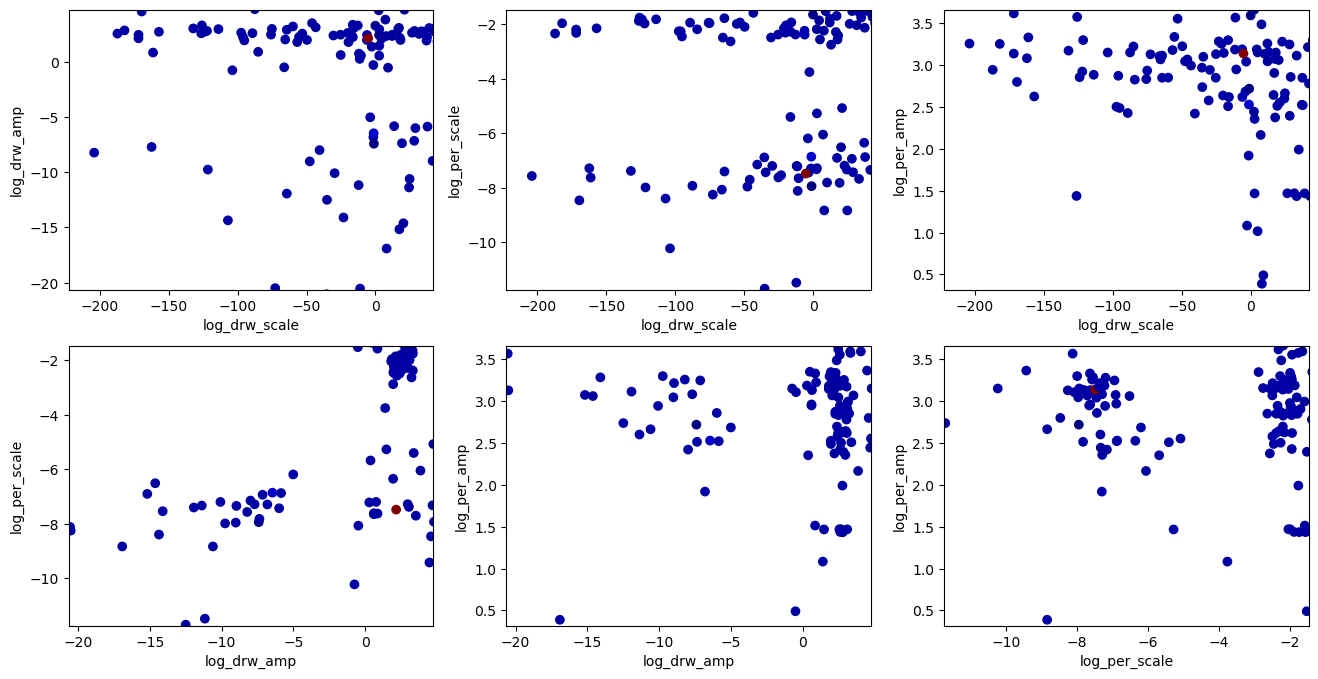

In [50]:
res = res_tsp_run_0_np
res_drw = res_tsp_run_0_drw_np

# larger numbers, bigger relative improvment
improvment = (res[:,0]-res_drw[:,0])/res_drw[:,0]

theta = res[2:6]

log_drw_scale = theta[0]
log_drw_amp = theta[1]
log_per_scale = theta[2]
log_per_amp = theta[3]

plt.figure(figsize=(16,8))
plt.subplot(2,3, 1)
plt.scatter(res[:,1],res[:,2], c=improvment, cmap='jet')
plt.xlabel('log_drw_scale')
plt.ylabel('log_drw_amp')
#plt.axvline(np.log10(drw_tau), ls=':')
#plt.axhline(np.log10(drw_amp), ls=':')
plt.xlim(np.quantile(res[:,1],0.05) - .1, np.quantile(res[:,1],0.95) + .1)
plt.ylim(np.quantile(res[:,2],0.05) - .1, np.quantile(res[:,2],0.95) + .1)


plt.subplot(2, 3, 2)
plt.scatter(res[:,1],res[:,3]-np.log10(2*np.pi), c=improvment, cmap='jet')
plt.xlabel('log_drw_scale')
plt.ylabel('log_per_scale')
# plt.axvline(np.log10(drw_tau), ls=':')
# plt.axhline(np.log10(per_tau), ls=':')
plt.xlim(np.quantile(res[:,1],0.05)- .1, np.quantile(res[:,1],0.95)+ .1)
plt.ylim(np.quantile(res[:,3],0.05)-np.log10(2*np.pi) - .1, np.quantile(res[:,3],0.95)-np.log10(2*np.pi)+ .1)

plt.subplot(2, 3, 3)
plt.scatter(res[:,1],res[:,4], c=improvment, cmap='jet')
plt.xlabel('log_drw_scale')
plt.ylabel('log_per_amp')
# plt.axvline(np.log10(drw_tau), ls=':')
# plt.axhline(np.log10(per_amp), ls=':')
plt.xlim(np.quantile(res[:,1],0.05)- .1, np.quantile(res[:,1],0.95)+ .1)
plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1)

plt.subplot(2, 3, 4)
plt.scatter(res[:,2],res[:,3]-np.log10(2*np.pi), c=improvment, cmap='jet')
plt.xlabel('log_drw_amp')
plt.ylabel('log_per_scale')
# plt.axvline(np.log10(drw_amp), ls=':')
# plt.axhline(np.log10(per_tau), ls=':')
plt.xlim(np.quantile(res[:,2],0.05)- .1, np.quantile(res[:,2],0.95)+ .1)
plt.ylim(np.quantile(res[:,3]-np.log10(2*np.pi),0.05)- .1, np.quantile(res[:,3]-np.log10(2*np.pi),0.95)+ .1)

plt.subplot(2, 3, 5)
plt.scatter(res[:,2],res[:,4], c=improvment, cmap='jet')
plt.xlabel('log_drw_amp')
plt.ylabel('log_per_amp')
# plt.axvline(np.log10(drw_amp), ls=':')
# plt.axhline(np.log10(per_amp), ls=':')
plt.xlim(np.quantile(res[:,2],0.05)- .1, np.quantile(res[:,2],0.95)+ .1)
plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1)

plt.subplot(2, 3, 6)
plt.scatter(res[:,3]-np.log10(2*np.pi),res[:,4], c=improvment, cmap='jet')
plt.xlabel('log_per_scale')
plt.ylabel('log_per_amp')
# plt.axhline(np.log10(per_amp), ls=':')
# plt.axvline(np.log10(per_tau), ls=':')
plt.xlim(np.quantile(res[:,3],0.05)-np.log10(2*np.pi)- .1, np.quantile(res[:,3],0.95)-np.log10(2*np.pi)+ .1)
plt.ylim(np.quantile(res[:,4],0.05)- .1, np.quantile(res[:,4],0.95)+ .1) 

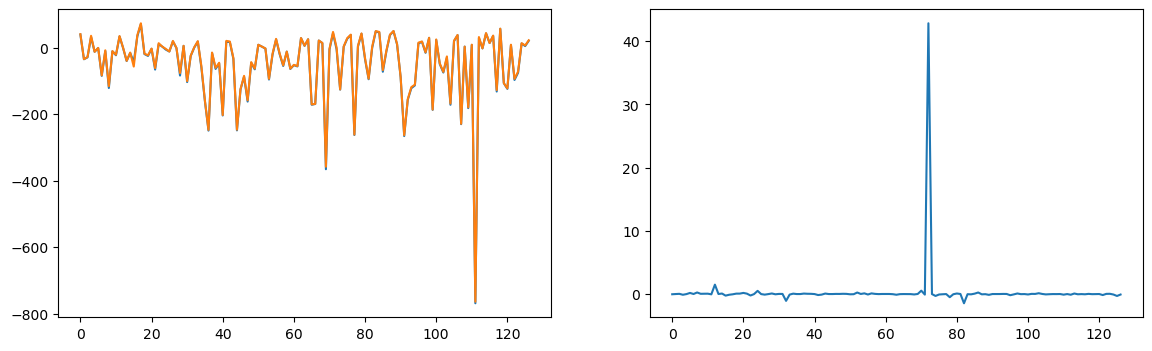

In [51]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(res[:,0])
plt.plot(res_drw[:,0])

plt.subplot(122)
plt.plot((res[:,0]-res_drw[:,0])/res_drw[:,0])

In [52]:
# shows which one have greates absolute improvment
df = pd.DataFrame(res_tsp_run_0['min_neg_log_lh']-res_tsp_run_0_drw['min_neg_log_lh'])
df.sort_values(by='min_neg_log_lh', inplace=True)
df

,min_neg_log_lh
SDSS_NAME_dr16q_constant,
024455.18-002501.5,-7.522515e+00
023922.87-000119.6,-7.513662e+00
024220.73-002059.7,-5.444676e+00
023945.93-001220.0,-5.172377e+00
024104.28+000821.3,-4.930120e+00
...,...
024425.39-004653.0,-1.085092e-06
024400.19-003637.9,-9.867513e-07
024332.13+002733.4,-9.947598e-14


# Simulations

In [8]:
# if running on baldur or epyc
data_path = "/epyc/users/ncaplar/data/drw_per_sim/"

col_map = ColumnMapper(id_col="lc_nr", 
                       time_col="t",
                       flux_col="y", 
                       err_col="yerr",
                       band_col="band")

ens.from_parquet(data_path,
                 source_subdir="sources",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=True,
                 sorted=True
                 )

In [9]:
ens_source = ens._source.compute()

In [10]:
res_sim_run_0_drw = pd.read_parquet(f"{basedir}/res_sim_run_g_0_drw_full.parquet", engine='pyarrow')
res_sim_run_0 = pd.read_parquet(f"{basedir}/res_sim_run_g_0_full.parquet", engine='pyarrow')
# numpy version of the results
# res_tsp_run_0_np = np.vstack(res_tsp_run_0.values)
# res_tsp_run_0_drw_np = np.vstack(res_tsp_run_0_drw.values)

In [11]:
res_sim_run_0_drw.loc[0]

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
lc_nr,,,,,,
0,-364.357856,-364.357856,2.437787,-1.281439,1.872701,-2.842854
0,-364.357856,-364.357856,2.437786,-1.281439,4.753572,0.182052
0,-364.357856,-363.112164,3.419242,-0.949396,3.659970,-1.428220
0,-364.357856,-364.319759,2.555514,-1.242976,2.993292,-0.457147
0,-364.357856,-337.969523,-2.861219,-5.563924,0.780093,1.537832
...,...,...,...,...,...,...
0,-364.357856,-364.357856,2.437786,-1.281439,2.468978,-1.253952
0,-364.357856,-364.357856,2.437786,-1.281439,2.613664,0.629778
0,-364.357856,-364.357856,2.437786,-1.281439,2.137705,1.485551


In [12]:
ngridx = 100
ngridy = 100

import matplotlib.tri as tri

x = res_sim_run_0_drw.loc[0]['log_drw_scale'][0:100]
y = res_sim_run_0_drw.loc[0]['log_drw_amp'][0:100]
z =  res_sim_run_0_drw.loc[0]['neg_log_lh'][0:100]


x_min = np.quantile(x,0.2)-0.4
x_max = np.quantile(x,0.80)+0.4
y_min = np.quantile(y,0.2)-0.4
y_max = np.quantile(y,0.80)+0.4

xi = np.linspace(x_min, x_max, ngridx)
yi = np.linspace(y_min, y_max, ngridy)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

In [13]:
true_values_single = np.unique([np.log10(ens_source.loc[0]['drw_amp']), np.log10(ens_source.loc[0]['drw_tau'])])

Text(0, 0.5, 'log_drw_amp')

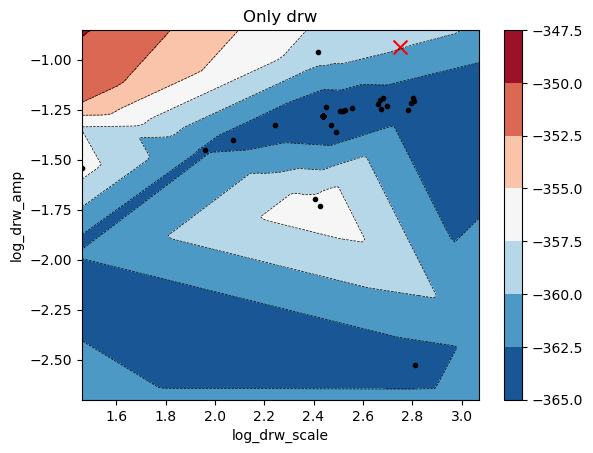

In [14]:
fig, (ax1) = plt.subplots(nrows=1)
npts = 200
ax1.contour(xi, yi, zi, levels=5, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3)
ax1.scatter(true_values_single[1], true_values_single[0], marker='x', color='red', s=100)
ax1.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
ax1.set_title('Only drw')
ax1.set_xlabel('log_drw_scale')
ax1.set_ylabel('log_drw_amp')

In [15]:
def create_triangulation(x,y,z):
    x_min = np.quantile(x,0.2)-0.4
    x_max = np.quantile(x,0.80)+0.4
    y_min = np.quantile(y,0.2)-0.4
    y_max = np.quantile(y,0.80)+0.4

    xi = np.linspace(x_min, x_max, ngridx)
    yi = np.linspace(y_min, y_max, ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    return xi, yi, zi, x_min, x_max, y_min, y_max

def custom_log10(x):
    result = np.where(x == 0, -99, np.log10(x))
    return result


In [16]:
i_lc = 0
drw_amp_true = np.unique(np.log10(ens_source.loc[i_lc]['drw_amp']))[0]
drw_tau_true = np.unique(np.log10(ens_source.loc[i_lc]['drw_tau']))[0]
per_amp_true = np.unique(np.log10(ens_source.loc[i_lc]['per_amp']))[0]
per__true = np.unique(np.log10(ens_source.loc[i_lc]['per_tau']))[0]


/astro/users/ncaplar/.conda/envs/tape_static/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
min_res=res_sim_run_0.loc[i_lc][res_sim_run_0.loc[i_lc]['neg_log_lh']==res_sim_run_0.loc[i_lc]['min_neg_log_lh'].values[0]]
drw_amp_min = min_res['log_drw_amp'].values[0]
drw_scale_min = min_res['log_drw_scale'].values[0]
per_amp_min = min_res['log_per_amp'].values[0]
per_scale_min = min_res['log_per_scale'].values[0]


In [21]:
drw_amp_min

-1.351352437892073

drw_amp_true, drw_scale_true, per_amp_true, per_scale_true
[-0.935381, 2.7498, -1.4088081118792435, 1.5774440608032094]


Text(0, 0.5, 'log_per_amp')

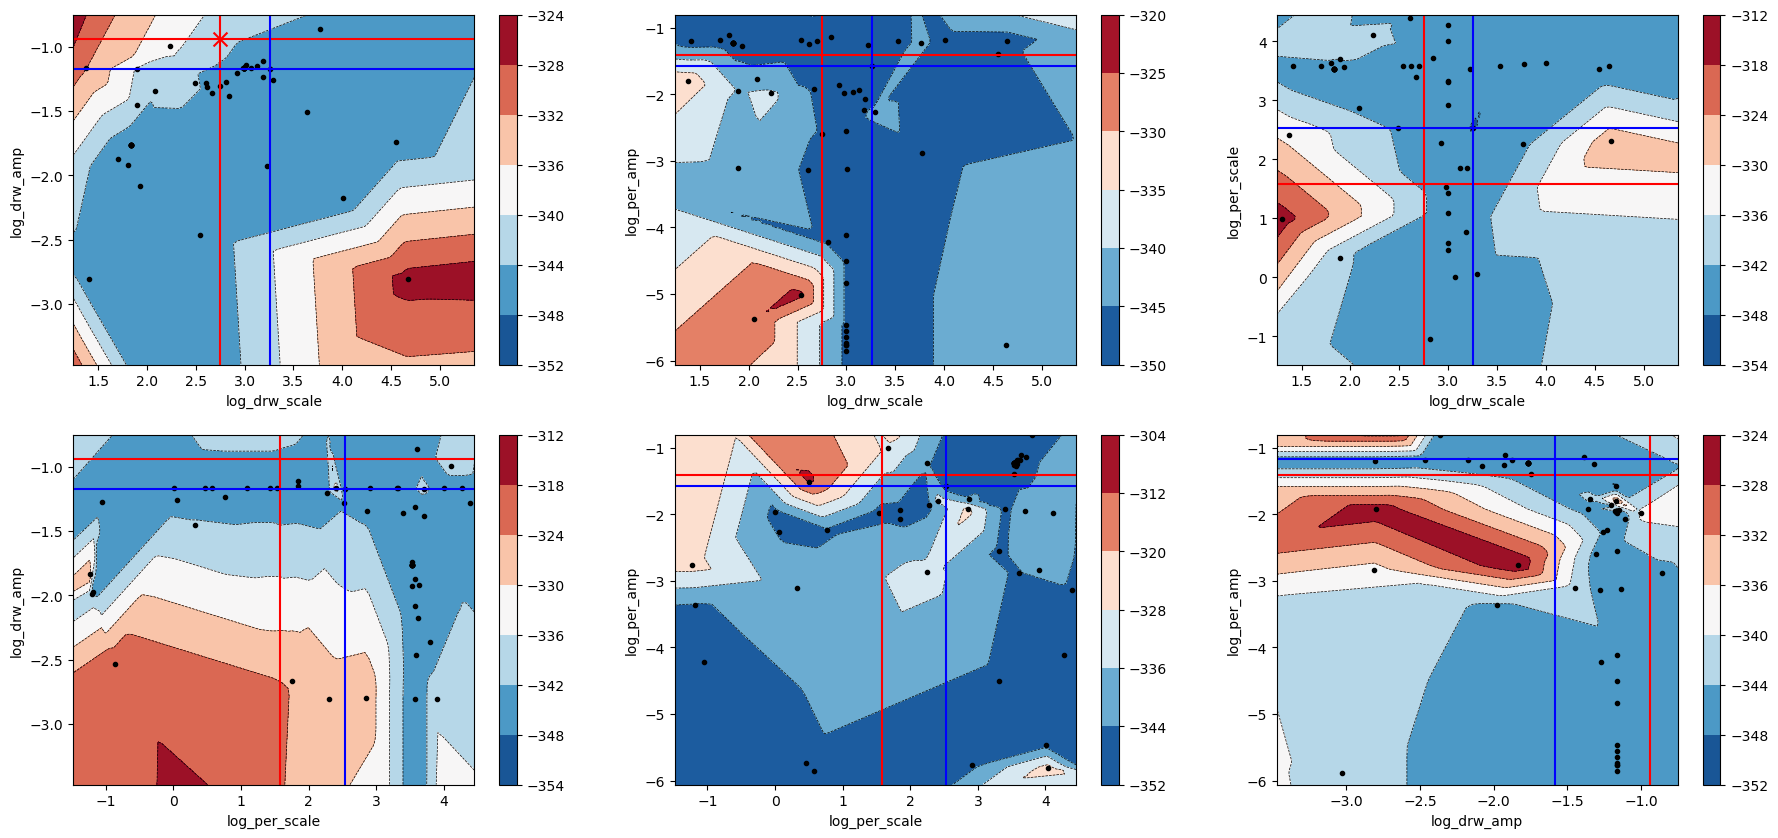

In [22]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(22, 10))
npts = 200

i_lc = 1
drw_amp_true = np.unique(np.log10(ens_source.loc[i_lc]['drw_amp']))[0]
drw_scale_true = np.unique(np.log10(ens_source.loc[i_lc]['drw_tau']))[0]
per_amp_true = np.unique(np.log10(ens_source.loc[i_lc]['per_amp']))[0]
per_scale_true = np.unique(np.log10(ens_source.loc[i_lc]['per_tau']))[0]

print('drw_amp_true, drw_scale_true, per_amp_true, per_scale_true')
print([drw_amp_true, drw_scale_true, per_amp_true, per_scale_true])

min_res=res_sim_run_0.loc[i_lc][res_sim_run_0.loc[i_lc]['neg_log_lh']==res_sim_run_0.loc[i_lc]['min_neg_log_lh'].values[0]]
drw_amp_min = min_res['log_drw_amp'].values[0]
drw_scale_min = min_res['log_drw_scale'].values[0]
per_amp_min = min_res['log_per_amp'].values[0]
per_scale_min = min_res['log_per_scale'].values[0]


z = res_sim_run_0.loc[i_lc]['neg_log_lh'][0:100]


x = res_sim_run_0.loc[i_lc]['log_drw_scale'][0:100]
y = res_sim_run_0.loc[i_lc]['log_drw_amp'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax1.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3)
ax1.scatter(drw_scale_true, drw_amp_true, marker='x', color='red', s=100)
ax1.axvline(drw_scale_true, color='red')
ax1.axhline(drw_amp_true, color='red')
ax1.axvline(drw_scale_min, color='blue')
ax1.axhline(drw_amp_min, color='blue')
ax1.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax1.set_title('Only drw')
ax1.set_xlabel('log_drw_scale')
ax1.set_ylabel('log_drw_amp')

# Figure 2
x = res_sim_run_0.loc[i_lc]['log_drw_scale'][0:100]
y = res_sim_run_0.loc[i_lc]['log_per_amp'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax2.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr2 = ax2.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3)
ax2.axvline(drw_scale_true, color='red')
ax2.axhline(per_amp_true, color='red')
ax2.axvline(drw_scale_min, color='blue')
ax2.axhline(per_amp_min, color='blue')
ax2.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax2.set_title('Only drw')
ax2.set_xlabel('log_drw_scale')
ax2.set_ylabel('log_per_amp')

# Figure 3
x = res_sim_run_0.loc[i_lc]['log_drw_scale'][0:100]
y = res_sim_run_0.loc[i_lc]['log_per_scale'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax3.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr3 = ax3.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr3, ax=ax3)
ax3.plot(x, y, 'ko', ms=3)
ax3.axvline(drw_scale_true, color='red')
ax3.axhline(per_scale_true, color='red')
ax3.axvline(drw_scale_min, color='blue')
ax3.axhline(per_scale_min, color='blue')
ax3.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax3.set_title('Only drw')
ax3.set_xlabel('log_drw_scale')
ax3.set_ylabel('log_per_scale')

# Figure 4
x = res_sim_run_0.loc[i_lc]['log_per_scale'][0:100]
y = res_sim_run_0.loc[i_lc]['log_drw_amp'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax4.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr4 = ax4.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr4, ax=ax4)
ax4.plot(x, y, 'ko', ms=3)
ax4.axhline(drw_amp_true, color='red')
ax4.axvline(per_scale_true, color='red')
ax4.axhline(drw_amp_min, color='blue')
ax4.axvline(per_scale_min, color='blue')
ax4.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax4.set_title('Only drw')
ax4.set_xlabel('log_per_scale')
ax4.set_ylabel('log_drw_amp')

# Figure 5
x = res_sim_run_0.loc[i_lc]['log_per_scale'][0:100]
y = res_sim_run_0.loc[i_lc]['log_per_amp'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax5.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr5 = ax5.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr5, ax=ax5)
ax5.plot(x, y, 'ko', ms=3)
ax5.axhline(per_amp_true, color='red')
ax5.axvline(per_scale_true, color='red')
ax5.axhline(per_amp_min, color='blue')
ax5.axvline(per_scale_min, color='blue')
ax5.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax5.set_title('Only drw')
ax5.set_xlabel('log_per_scale')
ax5.set_ylabel('log_per_amp')

# Figure 6
x = res_sim_run_0.loc[i_lc]['log_drw_amp'][0:100]
y = res_sim_run_0.loc[i_lc]['log_per_amp'][0:100]
xi, yi, zi, x_min, x_max, y_min, y_max = create_triangulation(x, y, z)
ax6.contour(xi, yi, zi,
            levels=5, linewidths=0.5, colors='k')
cntr6 = ax6.contourf(xi, yi, zi, levels=5, cmap="RdBu_r")

fig.colorbar(cntr6, ax=ax6)
ax6.plot(x, y, 'ko', ms=3)
ax6.axhline(per_amp_true, color='red')
ax6.axvline(drw_amp_true, color='red')
ax6.axvline(per_amp_min, color='blue')
ax6.axhline(drw_amp_min, color='blue')
ax6.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
if i_lc == 0:   
    ax6.set_title('Only drw')
ax6.set_xlabel('log_drw_amp')
ax6.set_ylabel('log_per_amp')

In [23]:
res_sim_run_0.loc[i_lc]

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
lc_nr,,,,,,,,,,
1,-348.27417,-347.769288,1.834823,-1.767094,3.537550,-1.229066,1.872701,-2.842854,3.210158,-2.857875
1,-348.27417,-344.585282,3.291248,-1.254771,0.051252,-2.264123,4.753572,0.182052,0.420700,-1.538775
1,-348.27417,-341.978755,-8.428186,24.200035,-114.595629,-5.630124,3.659970,-1.428220,0.808144,-1.513253
1,-348.27417,-347.769288,1.834823,-1.767094,3.537550,-1.229066,2.993292,-0.457147,4.492771,-1.247068
1,-348.27417,-310.751090,28.973072,3.697623,0.508493,-1.509110,0.780093,1.537832,3.032145,-1.003249
...,...,...,...,...,...,...,...,...,...,...
1,-348.27417,-342.811985,2.490254,-1.278610,2.522969,-0.457494,2.468978,-1.253952,2.611216,-0.440417
1,-348.27417,-347.769288,1.834823,-1.767094,3.537550,-1.229066,2.613664,0.629778,3.849968,-0.639365
1,-348.27417,-340.671659,-3.515309,-3.613195,-5.688574,-3.316901,2.137705,1.485551,1.079105,-1.820266


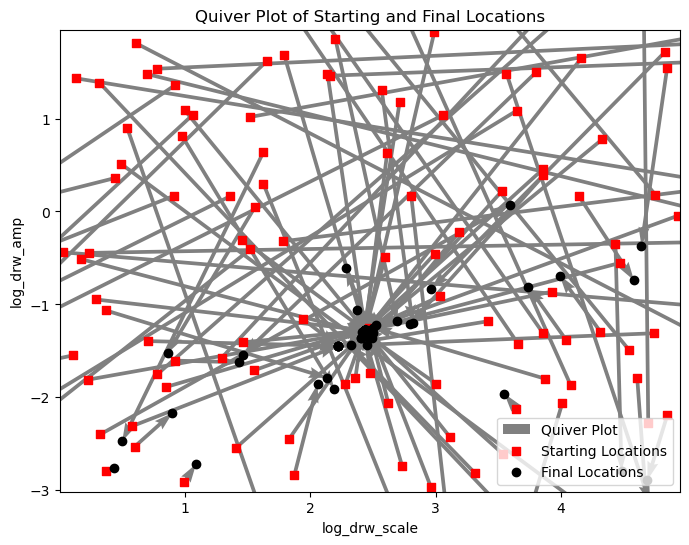

In [24]:
i_lc = 0
# Assuming you have the starting and final locations for amplitude and period
init_amp = res_sim_run_0.loc[i_lc]['init_log_drw_amp']
init_per = res_sim_run_0.loc[i_lc]['init_log_drw_scale']

final_amp = res_sim_run_0.loc[i_lc]['log_drw_amp']
final_per = res_sim_run_0.loc[i_lc]['log_drw_scale']

# Calculate the differences between final and initial locations
delta_amp = final_amp - init_amp
delta_per = final_per - init_per

# Create a quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(init_per, init_amp, delta_per, delta_amp, angles='xy', scale_units='xy', scale=1, color='grey', linestyle='-', label='Quiver Plot')
plt.scatter(init_per, init_amp, color='r', marker='s', label='Starting Locations')
plt.scatter(final_per, final_amp, color='black', marker='o', label='Final Locations')

# Set labels and title
plt.xlabel('log_drw_scale')
plt.ylabel('log_drw_amp')
plt.title('Quiver Plot of Starting and Final Locations')
plt.legend()

plt.xlim(np.quantile(init_per,0.01)- .1, np.quantile(init_per,0.99)+ .1)
plt.ylim(np.quantile(init_amp,0.01)- .1, np.quantile(init_amp,0.99)+ .1)
# Show the plot
plt.show()

# seems completly random

In [36]:
i_lc = 0
single_lc_res = res_sim_run_0.loc[i_lc]
min_ln_s_lc_res = single_lc_res['min_neg_log_lh'].values[0]
# best parameters for a single light curve
min_single_lc_res = single_lc_res[single_lc_res['neg_log_lh']==min_ln_s_lc_res]

def find_best_param_for_lc(single_lc_res):
    "find best parameters for a single light curve"
    min_ln_s_lc_res = single_lc_res['min_neg_log_lh'].values[0]
    # best parameters for a single light curve
    min_single_lc_res = single_lc_res[single_lc_res['neg_log_lh']==min_ln_s_lc_res]
    return min_single_lc_res.iloc[0]

In [26]:
ens_source.loc[0]

,drw_amp,drw_tau,per_amp,per_tau,t,y,yerr,y_drw,y_per,band,provenance
lc_nr,,,,,,,,,,,
0,0.116043,562.082417,0.0,9999999.0,0.000000,15.380592,0.014706,15.419055,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,7.056726,15.359813,0.014842,15.393766,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,9.997028,15.402470,0.014847,15.392826,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,14.113451,15.385593,0.014803,15.400872,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,17.053754,15.432630,0.014732,15.414105,-0.0,g,survey_1
...,...,...,...,...,...,...,...,...,...,...,...
0,0.116043,562.082417,0.0,9999999.0,1504.062670,15.191266,0.015769,15.243157,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,1506.022871,15.248095,0.015721,15.250262,-0.0,g,survey_1
0,0.116043,562.082417,0.0,9999999.0,1508.963174,15.246760,0.015794,15.239501,-0.0,g,survey_1


In [27]:
ens_source.loc[1]

,drw_amp,drw_tau,per_amp,per_tau,t,y,yerr,y_drw,y_per,band,provenance
lc_nr,,,,,,,,,,,
1,0.116043,562.082417,0.039011,37.795845,0.000000,15.177932,0.016222,15.202965,-0.023621,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,7.056726,15.215078,0.015874,15.208397,0.019477,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,9.997028,15.241378,0.015942,15.185151,0.033068,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,14.113451,15.199840,0.015952,15.178012,0.038707,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,17.053754,15.255481,0.015887,15.194172,0.031889,g,survey_1
...,...,...,...,...,...,...,...,...,...,...,...
1,0.116043,562.082417,0.039011,37.795845,1504.062670,15.060257,0.017425,15.065364,-0.036351,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,1506.022871,14.987536,0.017534,15.055507,-0.038971,g,survey_1
1,0.116043,562.082417,0.039011,37.795845,1508.963174,15.042803,0.017387,15.068761,-0.035242,g,survey_1


In [28]:
# best parameters for the light curve without added periods, analyzed with a model that includes periods
find_best_param_for_lc(res_sim_run_0.loc[i_lc])

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
lc_nr,,,,,,,,,,
0,-365.549095,-365.549095,2.463119,-1.351352,2.523581,-1.640469,2.468978,-1.253952,2.611216,-0.440417


In [37]:
# best parameters for the light curve without added periods, analyzed with a drw model
find_best_param_for_lc(res_sim_run_0_drw.loc[i_lc])

min_neg_log_lh       -364.357856
neg_log_lh           -364.357856
log_drw_scale           2.437786
log_drw_amp            -1.281439
init_log_drw_scale      2.989500
init_log_drw_amp        1.928252
Name: 0, dtype: float64

In [30]:
find_best_param_for_lc(res_sim_run_0.loc[1])

,min_neg_log_lh,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
lc_nr,,,,,,,,,,
1,-348.27417,-348.27417,3.25839,-1.171447,2.533932,-1.584144,0.852621,-1.889461,2.513185,-0.915923


In [42]:
min_res_sim_run_0_drw = res_sim_run_0_drw.groupby(level=0).apply(find_best_param_for_lc)
min_res_sim_run_0 = res_sim_run_0.groupby(level=0).apply(find_best_param_for_lc)

In [63]:
# these simulations were done for 023922.87-000119.6

# find results for that object
res_tsp_slc = res_tsp_run_0[res_tsp_run_0.index =='023922.87-000119.6']
res_tsp_slc_drw = res_tsp_run_0_drw[res_tsp_run_0_drw.index =='023922.87-000119.6']

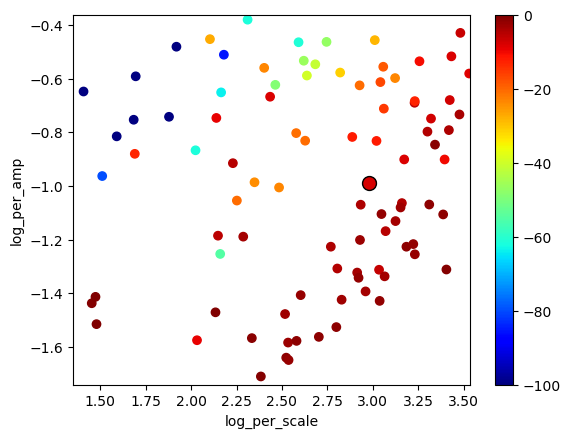

In [84]:
# plot difference in min_neg_log_lh between res_sim_run_0 and res_sim_run_0_drw as a function of log_per_scale and log_per_amp

diff_min_neg_log_lh = min_res_sim_run_0['min_neg_log_lh'] - min_res_sim_run_0_drw['min_neg_log_lh']
diff_res_tsp_slc_log_lh = res_tsp_slc['min_neg_log_lh'] - res_tsp_slc_drw['min_neg_log_lh']
# simulations
plt.scatter(min_res_sim_run_0['log_per_scale'], min_res_sim_run_0['log_per_amp'], c=diff_min_neg_log_lh, cmap='jet', vmax=0, vmin=-100)
# original (but wrong drw periods)
plt.scatter(res_tsp_slc['log_per_scale'], res_tsp_slc['log_per_amp'], c=diff_res_tsp_slc_log_lh,
            cmap='jet', s=100, vmax=0, vmin=-100, edgecolors='black')
plt.xlabel('log_per_scale')
plt.ylabel('log_per_amp')
plt.xlim(np.quantile(min_res_sim_run_0['log_per_scale'],0.05)- .1, np.quantile(min_res_sim_run_0['log_per_scale'],0.95)+ .1)
plt.ylim(np.quantile(min_res_sim_run_0['log_per_amp'],0.05)- .1, np.quantile(min_res_sim_run_0['log_per_amp'],0.95)+ .1)
plt.colorbar()
plt.show() 
